In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from simulators.oup import oup
import utils.corruption as corruption
from itertools import permutations
from utils.metrics import *
import random
import os 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def RMSE(gt, samples, p=1):
    if p == 1:
        dist = torch.mean(torch.abs(gt-samples))
    elif p == 2:
        dist = torch.sqrt(torch.mean((gt-samples)**2))
    elif p == 3:
        dist = torch.nn.functional.pairwise_distance(gt, samples, p=2).mean()
    else:
        dist = metrics.MMD_unweighted(samples, gt.reshape(-1, 2), lengthscale=metrics.median_heuristic(samples))
    return dist

In [3]:
N=100

x = torch.tensor(np.load("data/oup_x_4000.npy")).reshape(4000, N, 25).to(device)
theta = np.load("data/oup_theta_4000.npy")

dataloader = DataLoader(x[:1000], batch_size=50, shuffle=True)


n_corrupted = int(100 * 0.2)
n_normal = int(100 - n_corrupted)
    
theta_gt = torch.tensor([0.5, 1.0])

theta_cont = torch.tensor([-0.5, 1])
oup_obs = oup(var=1, N=N)
obs = oup_obs(theta_gt).to(device)
oup_obs_cont = oup(var=1, N=N)
obs_2 = oup_obs_cont(theta_cont).to(device)
obs_cont = torch.cat([obs[:n_normal], obs_2[:n_corrupted]], dim=0).reshape(-1, N, 25)
print(obs_cont.shape)

torch.Size([1, 100, 25])


In [11]:
def regression_ABC(s_obs, param, sumStats, p):
    def mad(data):
        return np.mean(np.abs(data - np.mean(data, axis=0)), axis=0)

    if param.shape[0] < param.shape[1]:
        param = np.transpose(param)

    if sumStats.shape[0] < sumStats.shape[1]:
        sumStats = np.transpose(sumStats)
    
    M = len(param)
    M_epsilon = int(M*p)
    sumStats = sumStats
    s_obs = s_obs

    norm_factor = mad(sumStats)

    norm_sumStats = sumStats / norm_factor
    norm_s_obs = s_obs / norm_factor

    distance = np.linalg.norm(norm_sumStats - norm_s_obs, axis = 1)
    max_accepted_distance = np.sort(distance)[M_epsilon - 1]

    posterior_samples = param[distance <= max_accepted_distance, :]
    norm_sumStats_star = norm_sumStats[distance <= max_accepted_distance, :]

    weights = 1 - (distance[distance <= max_accepted_distance] / max_accepted_distance)**2
    W = np.diag(weights)

    s_obs_norm = np.tile(norm_s_obs, (M_epsilon,1))
    X = np.column_stack((np.ones(shape = (M_epsilon,1)), norm_sumStats_star - s_obs_norm))

    A = np.matmul(X.T, W)

    solution = np.linalg.solve(np.matmul(A, X), np.matmul(A, posterior_samples))

    beta = solution[1:,:]

    posterior_samples_adjusted = posterior_samples - np.matmul((norm_sumStats_star - s_obs_norm), beta)

    return posterior_samples_adjusted
    

In [29]:
class OUPSummary(nn.Module):
    def __init__(self, input_size, hidden_dim, N):
        super(OUPSummary, self).__init__()
        self.N = N
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.num_layers = 1
#         self.lstm = nn.LSTM(1, self.hidden_dim, self.num_layers, batch_first=True)

        self.encoder = nn.Sequential(nn.Conv1d(self.input_size, 4, 3, 2),
                                     nn.Conv1d(4, 4, 3, 2),
                                     nn.Conv1d(4, 4, 3, 3))
        
        self.decoder = nn.Sequential(nn.ConvTranspose1d(4, 4, 3, 3),
                                     nn.ConvTranspose1d(4, 4, 3, 2),
                                     nn.ConvTranspose1d(4, self.input_size, 3, 2),
                                     nn.Upsample(25))

    def forward(self, Y):
#         current_device = Y.device
        batch_size = Y.size(0)
        embeddings = self.encoder(Y.reshape(-1, 1, 25))
#         print(embeddings.shape)
#         stat_conv = torch.mean(embeddings_conv, dim=1)

#         hidden, c = self.init_hidden(self.N * batch_size, current_device)
#         out, (embeddings_lstm, c) = self.lstm(Y.reshape(self.N * batch_size, 25, 1), (hidden, c))

#         embeddings_lstm = embeddings_lstm.reshape(batch_size, self.N, self.hidden_dim)

#         stat_lstm = torch.mean(embeddings_lstm, dim=1)
#         stat = torch.cat([stat_conv, stat_lstm], dim=1)
        output = self.decoder(embeddings.reshape(-1, 4, 1)).reshape(-1, 100, 25)
        return output
#         return embeddings_lstm, stat

#     def init_hidden(self, batch_size, current_device):
#         hidden = torch.zeros(1 * self.num_layers, batch_size, self.hidden_dim).to(current_device)
#         c = torch.zeros(1 * self.num_layers, batch_size, self.hidden_dim).to(current_device)
#         return hidden, c
    def forward_encoder(self, Y):
        embeddings = self.encoder(Y.reshape(-1, 1, 25)).reshape(-1, 100, 4)
        return embeddings

In [118]:
def solve_normal():
    summary_net_normal = OUPSummary(1, 4, 100).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(summary_net_normal.parameters(), lr=0.01)

    # Train the model for some number of epochs
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs = data
            optimizer.zero_grad()

            outputs = summary_net_normal(inputs)

            loss = criterion(outputs, inputs)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    return summary_net_normal

In [112]:
s_normal = torch.mean(summary_net_normal.forward_encoder(x).cpu(), dim=1).detach().numpy()
s_obs_normal = torch.mean(summary_net_normal.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()

posterior_normal = regression_ABC(s_obs_normal, theta, s_normal, 0.05)

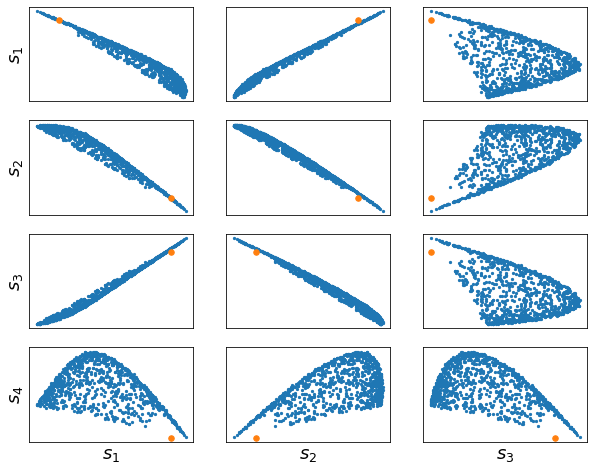

In [42]:
stat = list(permutations(range(4), 2))

plt.figure(figsize=(10, 8))
for i in range(len(stat)):
    plt.subplot(4, 3, i+1)
    plt.scatter(s_normal[:, stat[i][1]], s_normal[:, stat[i][0]], s=5)
    plt.scatter(s_obs_normal[0, stat[i][1]], s_obs_normal[0, stat[i][0]], s=30)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    if i%3==0:
        plt.ylabel("$s_{i}$".format(i=stat[i][0]+1), fontsize=18)
    if len(stat)-3 <= i < len(stat):
        plt.xlabel("$s_{i}$".format(i=stat[i][1]+1), fontsize=18, fontweight="bold")

In [119]:
def solve_robust(beta):
    summary_net_robust = OUPSummary(1, 4, 100).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(summary_net_robust.parameters(), lr=0.01)

    index_list = [int(i) for i in range(len(x))]

    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs = data.to(device)
            optimizer.zero_grad()

            outputs = summary_net_robust(inputs)

            random.shuffle(index_list)
            context_embeddings = torch.mean(summary_net_robust.forward_encoder(x[index_list[:200]]), dim=1)

            obs_embeddings = torch.mean(summary_net_robust.forward_encoder(obs_cont), dim=1)

            ae_loss = criterion(outputs, inputs)
            summary_loss = MMD_unweighted(context_embeddings, obs_embeddings, lengthscale=median_heuristic(context_embeddings))

            loss = ae_loss + beta*summary_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    return summary_net_robust

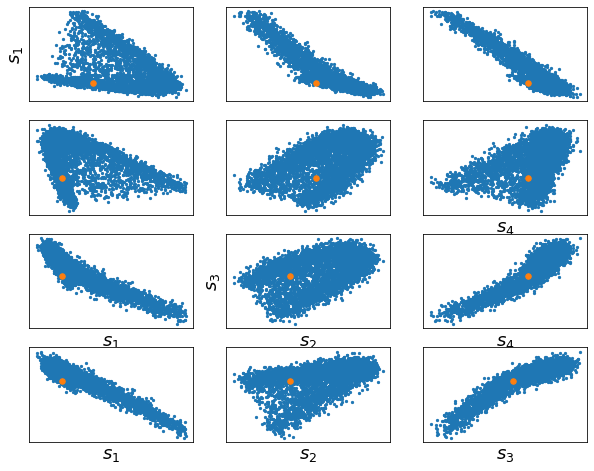

In [102]:
s_robust = torch.mean(summary_net_robust.forward_encoder(x).cpu(), dim=1).detach().numpy()
s_obs_robust = torch.mean(summary_net_robust.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()

stat = list(permutations(range(4), 2))
plt.figure(figsize=(10, 8))
for i in range(len(stat)):
    plt.subplot(4, 3, i+1)
    plt.scatter(s_robust[:, stat[i][1]], s_robust[:, stat[i][0]], s=5)
    plt.scatter(s_obs_robust[0, stat[i][1]], s_obs_robust[0, stat[i][0]], s=30)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    if i%7==0:
        plt.ylabel("$s_{i}$".format(i=stat[i][0]+1), fontsize=18)
    if len(stat)-7 <= i < len(stat):
        plt.xlabel("$s_{i}$".format(i=stat[i][1]+1), fontsize=18, fontweight="bold")


In [103]:
posterior_robust = regression_ABC(s_obs_robust, theta, s_robust, 0.05)

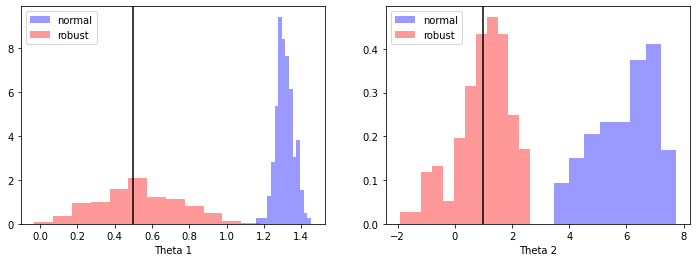

In [104]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(posterior_normal[:, 0], color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(posterior_robust[:, 0], color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
# plt.xlim(2, 8)
plt.xlabel("Theta 1")

plt.subplot(1, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(posterior_normal[:, 1], color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(posterior_robust[:, 1], color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
# plt.xlim(0, 25)
plt.xlabel("Theta 2")

plt.show()

In [105]:
RMSE(torch.tensor([0.5, 1.0]), torch.tensor(posterior_robust), 2)

tensor(0.6847, dtype=torch.float64)

In [106]:
RMSE(torch.tensor([0.5, 1.0]), torch.tensor(posterior_normal), 2)

tensor(3.6141, dtype=torch.float64)

In [133]:
n_sims = 50
beta_list = [10]
for beta in beta_list:
    for i in range(n_sims):
        print(f"Simulation {i}")
        summary_net_normal = solve_normal()
        s_normal = torch.mean(summary_net_normal.forward_encoder(x).cpu(), dim=1).detach().numpy()
        s_obs_normal = torch.mean(summary_net_normal.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()
        posterior_normal = regression_ABC(s_obs_normal, theta, s_normal, 0.05)

        summary_net_robust = solve_robust(beta)
        s_robust = torch.mean(summary_net_robust.forward_encoder(x).cpu(), dim=1).detach().numpy()
        s_obs_robust = torch.mean(summary_net_robust.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()
        posterior_robust = regression_ABC(s_obs_robust, theta, s_robust, 0.05)

        root_name = f'objects/ABC/oup/lambda={beta}/' + str(i)
        if not os.path.exists(root_name):
            os.makedirs(root_name)
        np.save(root_name + '/posterior_normal.npy', posterior_normal)
        np.save(root_name + '/posterior_robust.npy', posterior_robust)

Simulation 0
Epoch 1, Loss: 10.280038380622864
Epoch 2, Loss: 3.3131627321243284
Epoch 3, Loss: 2.540655589103699
Epoch 4, Loss: 1.8633566319942474
Epoch 5, Loss: 0.9194439828395844
Epoch 6, Loss: 0.5751935511827468
Epoch 7, Loss: 0.4944701060652733
Epoch 8, Loss: 0.4598919257521629
Epoch 9, Loss: 0.44259857535362246
Epoch 10, Loss: 0.4209157511591911
Epoch 1, Loss: 23.190514421463014
Epoch 2, Loss: 10.376377201080322
Epoch 3, Loss: 8.404172372817992
Epoch 4, Loss: 7.8703067064285275
Epoch 5, Loss: 7.2079856395721436
Epoch 6, Loss: 6.4930828332901
Epoch 7, Loss: 6.386155986785889
Epoch 8, Loss: 6.0934642314910885
Epoch 9, Loss: 5.5926331043243405
Epoch 10, Loss: 5.377948594093323
Simulation 1
Epoch 1, Loss: 12.414692902565003
Epoch 2, Loss: 3.141676390171051
Epoch 3, Loss: 1.9820102393627166
Epoch 4, Loss: 1.1029688894748688
Epoch 5, Loss: 0.6401991188526154
Epoch 6, Loss: 0.507820439338684
Epoch 7, Loss: 0.4588844612240791
Epoch 8, Loss: 0.43275149911642075
Epoch 9, Loss: 0.4155592381

Epoch 10, Loss: 6.305882143974304
Simulation 12
Epoch 1, Loss: 13.281019139289857
Epoch 2, Loss: 3.4103977560997008
Epoch 3, Loss: 2.5393306255340575
Epoch 4, Loss: 2.0282776951789856
Epoch 5, Loss: 1.4361540079116821
Epoch 6, Loss: 0.9606299459934234
Epoch 7, Loss: 0.7949583411216736
Epoch 8, Loss: 0.6966191202402114
Epoch 9, Loss: 0.6386973321437835
Epoch 10, Loss: 0.5774372965097427
Epoch 1, Loss: 23.991326332092285
Epoch 2, Loss: 9.437914896011353
Epoch 3, Loss: 7.807718896865845
Epoch 4, Loss: 7.10481321811676
Epoch 5, Loss: 6.9457128047943115
Epoch 6, Loss: 6.610457420349121
Epoch 7, Loss: 6.245474028587341
Epoch 8, Loss: 6.064104294776916
Epoch 9, Loss: 6.057068729400635
Epoch 10, Loss: 5.728627133369446
Simulation 13
Epoch 1, Loss: 17.323893117904664
Epoch 2, Loss: 4.761442375183106
Epoch 3, Loss: 2.2183178663253784
Epoch 4, Loss: 1.27855906188488
Epoch 5, Loss: 0.7210777640342713
Epoch 6, Loss: 0.5353554666042328
Epoch 7, Loss: 0.4655351653695107
Epoch 8, Loss: 0.4322661578655

Epoch 9, Loss: 5.464209342002869
Epoch 10, Loss: 5.431907153129577
Simulation 24
Epoch 1, Loss: 10.963554871082305
Epoch 2, Loss: 3.3437149047851564
Epoch 3, Loss: 2.244549107551575
Epoch 4, Loss: 1.7494864761829376
Epoch 5, Loss: 1.1707518249750137
Epoch 6, Loss: 0.8142218381166458
Epoch 7, Loss: 0.7099401384592057
Epoch 8, Loss: 0.6453659266233445
Epoch 9, Loss: 0.5793415039777756
Epoch 10, Loss: 0.5284492462873459
Epoch 1, Loss: 24.633283615112305
Epoch 2, Loss: 10.612683844566345
Epoch 3, Loss: 7.67048499584198
Epoch 4, Loss: 7.023763966560364
Epoch 5, Loss: 6.750689744949341
Epoch 6, Loss: 6.636231708526611
Epoch 7, Loss: 6.286005759239197
Epoch 8, Loss: 6.231301021575928
Epoch 9, Loss: 5.689536786079406
Epoch 10, Loss: 5.297407245635986
Simulation 25
Epoch 1, Loss: 13.917798888683318
Epoch 2, Loss: 2.987356996536255
Epoch 3, Loss: 1.8023617029190064
Epoch 4, Loss: 1.1043401122093202
Epoch 5, Loss: 0.754863166809082
Epoch 6, Loss: 0.5738345235586166
Epoch 7, Loss: 0.46359707415103

Epoch 8, Loss: 6.035539817810059
Epoch 9, Loss: 5.845480728149414
Epoch 10, Loss: 5.720719885826111
Simulation 36
Epoch 1, Loss: 18.415420985221864
Epoch 2, Loss: 3.3898123025894167
Epoch 3, Loss: 1.897004282474518
Epoch 4, Loss: 1.212976798415184
Epoch 5, Loss: 0.878817754983902
Epoch 6, Loss: 0.6814960062503814
Epoch 7, Loss: 0.5440518990159035
Epoch 8, Loss: 0.45425571501255035
Epoch 9, Loss: 0.4090480118989944
Epoch 10, Loss: 0.3840289205312729
Epoch 1, Loss: 25.560946655273437
Epoch 2, Loss: 12.711081504821777
Epoch 3, Loss: 8.324584484100342
Epoch 4, Loss: 7.168366479873657
Epoch 5, Loss: 6.613369274139404
Epoch 6, Loss: 6.348619437217712
Epoch 7, Loss: 6.423414278030395
Epoch 8, Loss: 6.139689540863037
Epoch 9, Loss: 5.850764274597168
Epoch 10, Loss: 5.7725821256637575
Simulation 37
Epoch 1, Loss: 16.62052676677704
Epoch 2, Loss: 3.5053393244743347
Epoch 3, Loss: 2.2643368422985075
Epoch 4, Loss: 1.9032941102981566
Epoch 5, Loss: 1.3998502552509309
Epoch 6, Loss: 0.9044411867856

Epoch 7, Loss: 6.147172665596008
Epoch 8, Loss: 6.325499105453491
Epoch 9, Loss: 6.026994323730468
Epoch 10, Loss: 5.7201454639434814
Simulation 48
Epoch 1, Loss: 9.938797116279602
Epoch 2, Loss: 2.898428738117218
Epoch 3, Loss: 2.3460588693618774
Epoch 4, Loss: 2.075269675254822
Epoch 5, Loss: 1.7217620491981507
Epoch 6, Loss: 1.2321153819561004
Epoch 7, Loss: 0.8980254679918289
Epoch 8, Loss: 0.6841781109571456
Epoch 9, Loss: 0.5768470257520676
Epoch 10, Loss: 0.4969455674290657
Epoch 1, Loss: 27.026254606246948
Epoch 2, Loss: 10.475365614891052
Epoch 3, Loss: 8.049564123153687
Epoch 4, Loss: 9.30879294872284
Epoch 5, Loss: 7.84367880821228
Epoch 6, Loss: 7.212452554702759
Epoch 7, Loss: 7.143667149543762
Epoch 8, Loss: 6.92907748222351
Epoch 9, Loss: 6.925385737419129
Epoch 10, Loss: 6.469904470443725
Simulation 49
Epoch 1, Loss: 17.053475165367125
Epoch 2, Loss: 3.989175045490265
Epoch 3, Loss: 2.1540067970752714
Epoch 4, Loss: 1.4146859049797058
Epoch 5, Loss: 0.9200172871351242
E

In [134]:
beta = 10
rmse_normal = np.zeros(n_sims)
rmse_robust = np.zeros(n_sims)
for i in range(n_sims):
    root_name = root_name = f'objects/ABC/oup/lambda={beta}/' + str(i)
    posterior_normal = torch.tensor(np.load(root_name + '/posterior_normal.npy'))
    posterior_robust = torch.tensor(np.load(root_name + '/posterior_robust.npy'))
    rmse_normal[i] = RMSE(torch.tensor([0.5, 1.0]), posterior_normal, 2)
    rmse_robust[i] = RMSE(torch.tensor([0.5, 1.0]), posterior_robust, 2)

print("RMSE mean for normal model: ", np.mean(rmse_normal))
print("RMSE mean for robust model: ", np.mean(rmse_robust))
print("RMSE std for normal model: ", np.std(rmse_normal))
print("RMSE std for robust model: ", np.std(rmse_robust))

RMSE mean for normal model:  5.599431977568908
RMSE mean for robust model:  0.8985368079753394
RMSE std for normal model:  2.379824189353463
RMSE std for robust model:  0.28525919762439367
